For this project, I chose to explore the provided baseball data. I mainly wanted to explore an often overlooked aspect of the game: the value of defense. I chose to look at how defense changes by position and by year. Also, I wanted to see what kind of relationship there is between offense and defense, and defense and salary (to see how defense is valued in a player).

In [33]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
bat = pd.read_csv('Batting.csv')
sal = pd.read_csv('Salaries.csv')
field_IF = pd.read_csv('Fielding.csv')

In [35]:
df = bat.merge(sal,how='inner',on=['playerID','yearID']).merge(field_IF,how='inner',on=['playerID','yearID'])
df = df[df['POS'] != 'P']
df['POS'] = df['POS'].str.replace("LF","OF")
df['POS'] = df['POS'].str.replace("CF","OF")
df['POS'] = df['POS'].str.replace("RF","OF")
print len(df)

46448


Here, I imported and cleaned the data. I used all-star, batting, salary and fielding information and merged them using year and playerID. Merging using inner ensures that none of my data points will be missing data in either of the three categories. It left me with 46448 data points, which is a large sample size. It also removed all data from years prior to 1985 as many of the statistics were not tracked until then.

I removed pitchers because many of them do not have batting or fielding stats. I also noticed that outfielders were categorized as CF, LF, RF or OF. I did not need to differentiate between which outfield position they played, so I grouped them all into one OF position. Even if I did want to look at the differences between the three positions (for example, CF generally have better defense than the corner outfield spots and many power hitters are corner outfielders), I had no way of figuring out the primary position of players labeled "OF," so for the sake of simplicity, I did not explore this.

In [36]:
def OPSfunc(dic):
    if dic['H'] > 0:
        OBP = (dic['H']+dic['BB']+dic['HBP'])/(dic['AB']+dic['BB']+dic['SF']+dic['HBP'])
        SLG = (dic['H']-dic['2B']-dic['3B']-dic['HR']+2*dic['2B']+3*dic['3B']+4*dic['HR'])/dic['AB']
        return OBP + SLG
    else:
        return 0

In [37]:
OPS = df.apply(OPSfunc,axis = 1)

In [38]:
df['OPS'] = OPS

To measure offensive ability, I used OPS, or On-base plus Slugging. On base percentage by itself favors players with higher averages, which slugging percentage favors power hitters, so OPS is generally accepted as a holistic statistic for hitters. I created a function to calculate this for one row and applied it to each row in the dataframe. Then, I appended this to the end of the dataframe.

In [39]:
pos = ['1B','2B','3B','SS','OF']
def DMetricfunc(dic):
    if dic['POS'] in pos:
        if dic['E']>0:
            return (dic['PO']+dic['A'])/dic['E']
        else:
            return (dic['PO']+dic['A'])
    elif dic['POS'] == 'C':
        if (dic['PB']+dic['WP']+dic['SB_y'])>0:
            return dic['CS_y']/(dic['PB']+dic['WP']+dic['SB_y'])
        else:
            return dic['CS_y']

In [40]:
DMetric = df.apply(DMetricfunc,axis = 1)

In [41]:
df['DMetric'] = DMetric

Measuring defensive ability was a lot trickier. There is a lot that goes into a good defender in baseball. For most positons, they need to be quick to get to the ball, be able to catch it cleanly, and throw it quickly and accurately. However, it is hard to track this using stats and only recently have more advanced stats, such as Zone rating which measures how often a play is made when a ball hit into a fielder's area, been used. 

Historically, only things like errors, putouts and assists been used, even though they don't take into account a fielder's range/speed (which is arguably the most important stat for a fielder). Still, using these imperfect statistics, I generated a Defensive Metric that is the ratio between positive plays to negative plays: the sum of putouts and assists divided by number of errors. If a fielder has no errors, I treated them as if they had 1. This should not have that much of an effect on my data since there should not be that many fielders with actaully 1 error.

For catchers, it is even more difficult. While they do have stats for fielded balls, catchers' defensive abilities are generally judged by how good they are behind the plate. They need to be able to block wild pitches and throw out base stealers. I took the ratio again of positive to negative plays: number of Caught Stealing divided by sum of passed balls, wild pitches and stolen bases allowed. This is a very poor stat as well because it is highly dependent on the pitcher that the catcher is catching for. For example, some knuckleballers have designated catchers, who will definitely have an inflated number of wild pitches and passed balls since the knuckleball is so unpredictable. Other catchers might catch for a pitcher who throws 95MPH+, in which case it is much easier to throw out a baserunner. Other catchers may have a very talented pitching staff, in which case there would probably be very few wild pitches and passed balls, and few runners who could attempt to steal a base. Still, since it is a ratio, it should at least give us some insight into a catcher's defensive ability.

In [42]:
f = {'Average':['mean'], 'Standard Deviation':['std']}
group = df.groupby('POS',as_index=False)['OPS','DMetric','salary'].agg(f)
print group

  POS Standard Deviation                             Average             \
                     OPS     DMetric        salary       OPS    DMetric   
                     std         std           std      mean       mean   
0  1B           0.167208  110.207008  3.714966e+06  0.720716  87.509594   
1  2B           0.152514   47.755957  2.361025e+06  0.657304  45.679454   
2  3B           0.163315   14.785704  2.945520e+06  0.677320  15.761954   
3   C           0.186702    9.477748  2.328885e+06  0.651254   6.285656   
4  DH           0.178384         NaN  1.596525e+06  0.713327        NaN   
5  OF           0.169007   50.924598  3.118982e+06  0.700045  41.097383   
6  SS           0.153479   26.355672  2.837129e+06  0.652220  28.548289   

            
    salary  
      mean  
0  2279561  
1  1474666  
2  1629841  
3  1367609  
4  1135338  
5  1890571  
6  1596899  


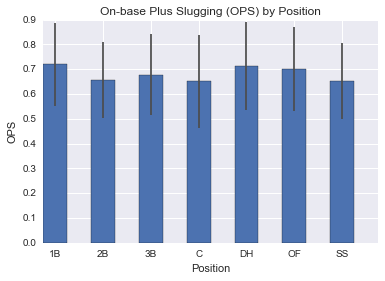

In [43]:
xticks=group['POS']

opacity = 0.4
error_config = {'ecolor': '0.3'}
bar_width = 0.5
plt.bar(group.index,
        group['Average']['OPS']['mean'],
        bar_width,
        yerr=group['Standard Deviation']['OPS']['std'],
        error_kw=error_config)
plt.xticks(np.arange(len(xticks)) + bar_width/2, xticks)
plt.title('On-base Plus Slugging (OPS) by Position')
plt.xlabel('Position')
plt.ylabel('OPS')

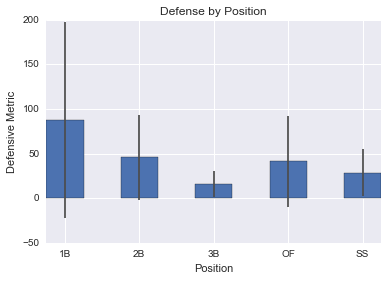

In [44]:
groupD = group[group['POS'] != 'C']
groupD = groupD[groupD['POS'] != 'DH']
groupD = groupD.reset_index(drop=True)
xticksD=groupD['POS']

opacity = 0.4
error_config = {'ecolor': '0.3'}
bar_width = 0.5
plt.bar(groupD.index,
        groupD['Average']['DMetric']['mean'],
        bar_width,
        yerr=groupD['Standard Deviation']['DMetric']['std'],
        error_kw=error_config)
plt.xticks(np.arange(len(xticksD)) + bar_width/2, xticksD)
plt.title('Defense by Position')
plt.xlabel('Position')
plt.ylabel('Defensive Metric')

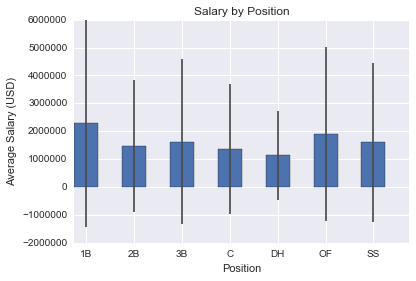

In [45]:
xticks=group['POS']
bar_width = 0.5
opacity = 0.4
error_config = {'ecolor': '0.3'}

plt.bar(group.index,
        group['Average']['salary']['mean'],
        bar_width,
        yerr=group['Standard Deviation']['salary']['std'],
        error_kw=error_config)
plt.xticks(np.arange(len(xticks)) + bar_width/2, xticks)
plt.title('Salary by Position')
plt.xlabel('Position')
plt.ylabel('Average Salary (USD)')

For the first 1D exploration, I did a groupby by position to look at the differences in offense, defense and salary. 

For OPS, we see that the best hitters are first basemen, designated hitters and outfielders. This is exactly what we expect since many good power hitters are not good fielders due to their speed and these are the positions where they would be the least detrimental. The standard deviation doesn't seem to differ much for each position. 

For defense, I only plotted the results for 1B, 2B, SS, 3B and OF since they use the same metric. The data seems to show that the closer you are to first base (where most putouts occur), the better fielder you are. This makes sense to a degree: fielders further away, such as shortstops and thirdbasemen, must throw further so they have a higher chance of making an error. Firstbasemen, on the other hand, only have to catch it, so make far fewer errors. Outfielders generally only get charged with errors if they drop a ball and generally not when they throw it. The standard deviation is very high as well. This is probably due to how highly errors are weighted in the metric. Errors will be much fewer than putouts or assists, let alone their sum. So just a couple of errors will very heavily penalize a player's Defensive Metric, especially for high volume positions such as 1B.

For salary, we see that the positions with best hitters, such as 1B and OF, have the highest, which makes sense. DH is much lower since they don't field at all. The standard deviation is high as expected; top baseball players have the highest salary of any major sport, so there is a large difference between their salaries and those of bench players.

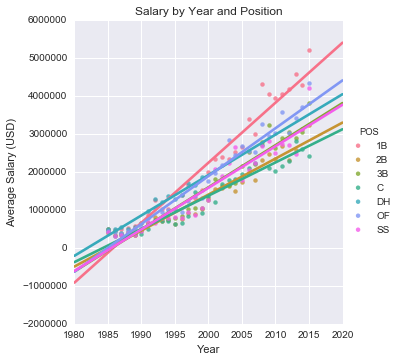

In [46]:
df[df.index.duplicated()]
yearPos=df.groupby(['POS','yearID'],as_index=False).mean()
sns.lmplot(x='yearID',y='salary',hue='POS',data=yearPos,ci=None)
plt.title('Salary by Year and Position')
plt.xlabel('Year')
plt.ylabel('Average Salary (USD)')

I also performed a groupby by year and position of the salary mainly to use the salary averages later, independent of year. Still, it was very interesting to see it plotted. First, as expected, salary in general increased a lot from 1985 to 2015. Second, it is interesting to see the relationships in the slopes of the regression lines as well. Firstbasemen are the highest paid players now, but in 1985, look like they were the least paid. Since they are the least important fielding position, perhaps in the past fielding was more highly valued.

In [47]:
df1B = df[df['POS'] == '1B']
df2B = df[df['POS'] == '2B']
df3B = df[df['POS'] == '3B']
dfSS = df[df['POS'] == 'SS']
dfOF = df[df['POS'] == 'OF']
dfC = df[df['POS'] == 'C']


In [48]:
def corrplot(posdf):
    x = posdf['OPS']
    y = posdf['DMetric']
    stdx = (x-x.mean())/x.std(ddof=0)
    stdy = (y-y.mean())/y.std(ddof=0)
    corr = stdx*stdy
    plt.scatter(stdx,stdy)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.title('Defense vs. Offense for ' + posdf['POS'].iloc[1])
    plt.xlabel('OPS in Standard Units')
    plt.ylabel('DMetric in Standard Units')
    print corr.mean()

0.220002973136


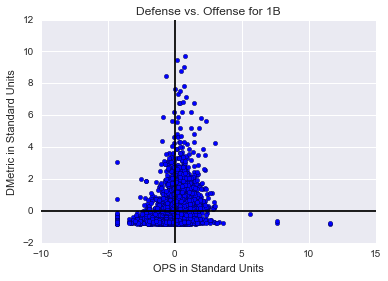

In [49]:
corrplot(df1B)

0.159553984423


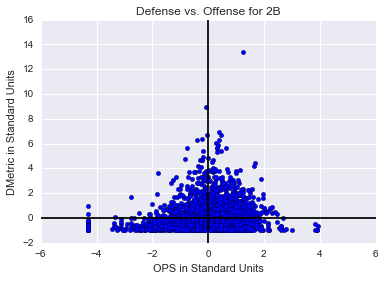

In [50]:
corrplot(df2B)

0.165829535937


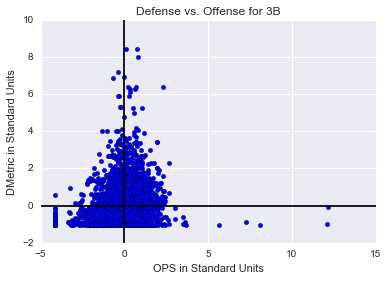

In [51]:
corrplot(df3B)

0.0786258913794


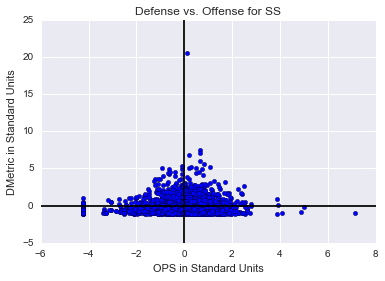

In [52]:
corrplot(dfSS)

0.180069602488


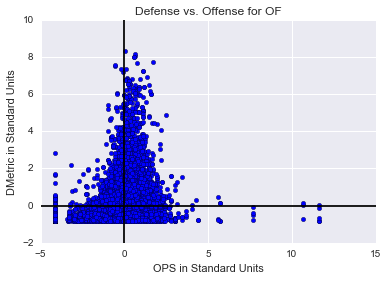

In [53]:
corrplot(dfOF)

0.17953936299


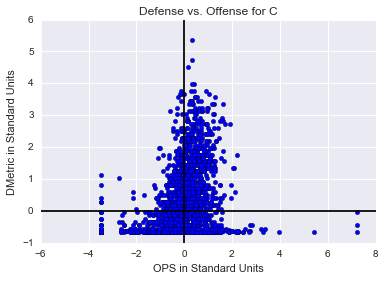

In [54]:
corrplot(dfC)

Next, I created a function to look at the relationship between offense and defense for each position. I initially expected there to be a overall negative correlation for every position. There should be a few players in the league who are good at both offense and defense, some good at offense but not defense, fewer who are good at defense but not offense, but pretty almost none who are bad at both since there would be no reason to give them a roster spot at that point. 

Looking at the data, it looks like every position has a loose positive correlation. This is pretty surprising based on my initial expectations. It can be attributed to a few things:
    1. My metric is a poor indicator of defense.
    2. We know that better offensive players will be in more games so will have more defensive stats all around. However, errors are so rare that players with few games at the position (and so are probably bad offensive players) and are unlucky enough to have an error will end up having both bad offense and bad defensive stats. This is made worse by my correction of 0 errors to 1 error. Better offensive players will have more games to accumulate more putouts and assists, and are statistically unlikely to have an error, so they will end up with better defensive stats.

yearID
1985    0.157804
1986    0.156438
1987    0.233317
1988    0.187169
1989    0.144180
1990    0.215171
1991    0.204631
1992    0.215733
1993    0.170108
1994    0.162505
1995    0.135551
1996    0.180235
1997    0.169436
1998    0.153693
1999    0.122509
2000    0.216642
2001    0.172914
2002    0.238482
2003    0.280504
2004    0.247886
2005    0.265940
2006    0.168860
2007    0.209367
2008    0.211314
2009    0.217771
2010    0.220083
2011    0.228178
2012    0.210199
2013    0.215625
2014    0.227116
2015    0.261317
Name: OPS, dtype: float64


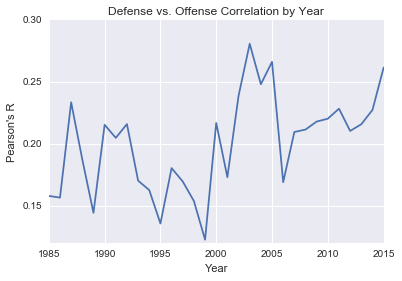

In [55]:
dfField = df[df['POS'] != 'DH']
CorByYear = dfField.groupby("yearID")['OPS'].corr(dfField['DMetric'],method='pearson')
CorByYear.plot()
plt.title('Defense vs. Offense Correlation by Year')
plt.xlabel('Year')
plt.ylabel('Pearson\'s R')
print CorByYear

I also chose to explore whether the correlation varied throughout baseball history. It did not seem to have a significant pattern.

In [56]:
f = {'Average':['mean'], 'Standard Deviation':['std']}
yearGroup=df.groupby(['POS','yearID'],as_index=False)['OPS','DMetric','salary'].agg(f)
print yearGroup

    POS yearID Standard Deviation                             Average  \
                              OPS     DMetric        salary       OPS   
                              std         std           std      mean   
0    1B   1985           0.143621  120.280915  4.072182e+05  0.707359   
1    1B   1986           0.118410   78.817489  4.422107e+05  0.734016   
2    1B   1987           0.134115   64.543831  5.163529e+05  0.752910   
3    1B   1988           0.142361   81.740432  5.150819e+05  0.661132   
4    1B   1989           0.154311   94.323546  5.571015e+05  0.677087   
5    1B   1990           0.171589   84.937779  6.073474e+05  0.690789   
6    1B   1991           0.173096   86.010186  8.460397e+05  0.657402   
7    1B   1992           0.131268  119.178982  1.310813e+06  0.680129   
8    1B   1993           0.151458   81.535839  1.349933e+06  0.741323   
9    1B   1994           0.182322   83.376547  1.285118e+06  0.755217   
10   1B   1995           0.195593   93.755667  1.68

In [57]:

df = df[df['POS'] != 'DH']
def salVsD(dic):
    year = dic['yearID']
    position = dic['POS']
    yearMask = yearGroup['yearID'] == year
    posMask = yearGroup['POS'] == position
    mask = yearMask & posMask
    datarow = yearGroup[mask]
    sUnitTemp = ((dic['salary']-datarow['Average']['salary']['mean'])/(datarow['Standard Deviation']['salary']['std'])).item()
    dUnitTemp = ((dic['DMetric']-datarow['Average']['DMetric']['mean'])/(datarow['Standard Deviation']['DMetric']['std'])).item()
    dic['Salary Unit']=sUnitTemp
    dic['DMetric Unit']=dUnitTemp
    dic['Correlation']=sUnitTemp * dUnitTemp
    return dic

In [58]:
df = df.apply(salVsD,axis = 1)



Lastly, I wanted to see how defense was valued. Is there any correlation between defense and salary? I used the mean and standard deviation of salary and my defensive metric calculated previously by year and position to account for the difference in salary by year. Without this, current players would be seemed to be valued more. I plotted this by position below.

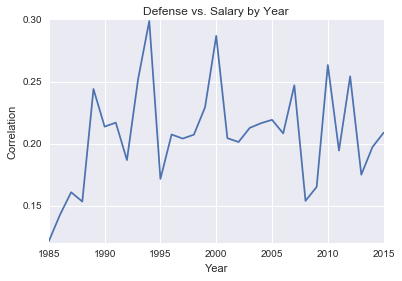

In [60]:
df.groupby('yearID')['Correlation'].mean().plot()
plt.title('Defense vs. Salary by Year')
plt.xlabel('Year')
plt.ylabel('Correlation')

In [61]:
DF1B = df[df['POS'] == '1B']
DF2B = df[df['POS'] == '2B']
DF3B = df[df['POS'] == '3B']
DFSS = df[df['POS'] == 'SS']
DFOF = df[df['POS'] == 'OF']
DFC = df[df['POS'] == 'C']

In [62]:
def SDcorrplot(posdf):
    x = posdf['Salary Unit']
    y = posdf['DMetric Unit']
    corr = posdf['Correlation']
    plt.scatter(x,y)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.title('Defense vs. Salary for ' + posdf['POS'].iloc[1])
    plt.xlabel('Salary in Standard Units')
    plt.ylabel('DMetric in Standard Units')
    print corr.mean()

0.265774628812


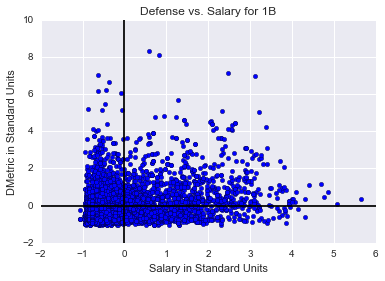

In [63]:
SDcorrplot(DF1B)

0.175192420388


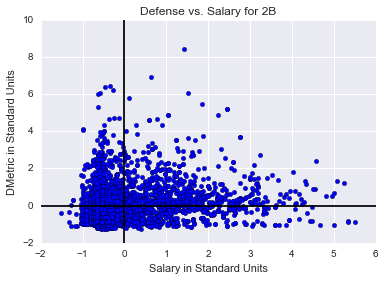

In [64]:
SDcorrplot(DF2B)

0.163555908804


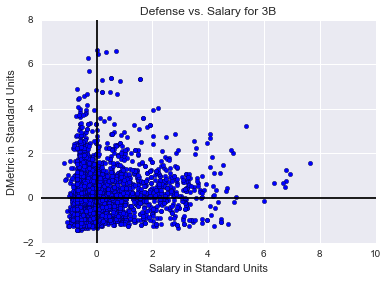

In [65]:
SDcorrplot(DF3B)

0.169891733852


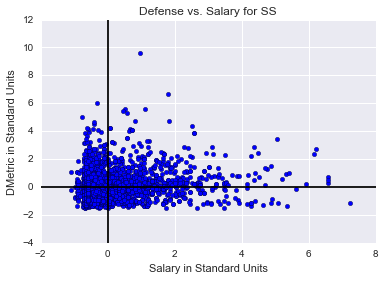

In [66]:
SDcorrplot(DFSS)

0.222115579022


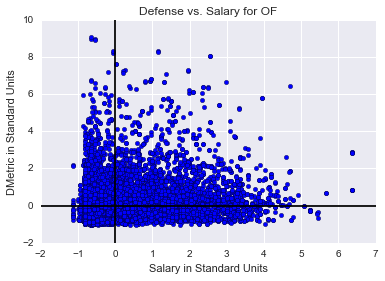

In [67]:
SDcorrplot(DFOF)

0.175937789423


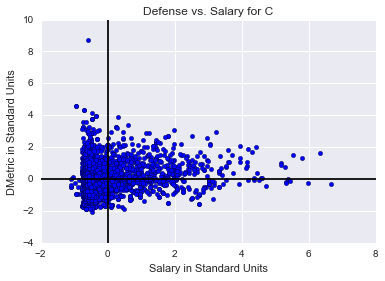

In [68]:
SDcorrplot(DFC)

There is a loose correlation between defense and salary. This can be one of two things:
    1. Teams do value defense! Players are paid slightly more when they have good defensive statistics.
    2. Players who are paid more play more games and are on the field more. My metric is poor and despite being a ratio of good plays to bad plays, simply rewards players who are on the field more. 



In summary, there is a clear difference in both offense and defense by position, while salary is around the same for all positions but are slightly higher for positions that have players who, on average, perform better on offense and defense. Also, there is a very loose correlation between Offense and Defense, and Defense and Salary (adjusted for year) for every position. Since Pearson's r is so small though, it can just be due to randomness, or just a poor result of my limited choice of Defense Metric, or it can be a real correlation showing that there are many "well-rounded" baseball players who are good at both offense and defense (or bad at both offense and defense) and are paid accordingly.

Overall, I am not confident enough to state that there are any correlations. A good next step would be to see if my Defensive Metric correlated with things as simple as games played, or if that correction I made for 0 errors affects the data in a significant way. In hindsight, it would have been good to add another parameter: how many putouts and assists do they get per game? This would be useful to judge a fielder's range, not just whether they make mistakes.

If given more resources, a better study would be to see if Gold Glove awards are deserved: Do they go to players who actually play defense (are able to make a good play on the ball often, even if it is far away) or do they just go to players who commit few errors (which may mean that they don't actually get to the ball as often) or simply make flashy plays on the field? This would be done using advanced metrics such as Defensive Runs Above Replacement or Zone Fielding Runs. Also, the correlation between Gold Gloves and All-star appearances, salary or MVPS would show whether or not defense is perceived as a valuable skill in baseball.